# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.metrics import mean_squared_error,r2_score
from pandas_datareader import data as pdr

# Loading data

In [ ]:
# Download monthly Fama–French 5 factors
ff5_daily = pdr.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2023')[0] / 100
ff5 = ff5_daily.resample('W-FRI').mean()  # convert daily to weekly means
# 1. Load Data
# --------------------------
tickers = ['TSLA', 'WMT', 'BAC', 'GS', 'LLY', 'MRK', 'GOOG','META', 'AAPL', 'XOM']
prices = yf.download(tickers, start='2023-07-01', end='2025-06-30', interval='1wk',auto_adjust=False)['Adj Close']
prices.head()

/tmp/ipython-input-1570181967.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5_daily = pdr.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='2023')[0] / 100
[*********************100%***********************]  10 of 10 completed


Ticker,AAPL,BAC,GOOG,GS,LLY,META,MRK,TSLA,WMT,XOM
Date,,,,,,,,,,
2023-07-03,188.575775,26.892981,119.323433,298.102570,444.701294,288.749969,101.698853,274.429993,49.817299,95.405533
2023-07-10,188.585678,27.439701,124.845642,308.525818,442.123993,306.977570,100.150032,281.380005,50.197041,93.352402
2023-07-17,189.821869,30.145021,119.492287,332.900360,454.498749,292.457092,102.995735,260.019989,51.401176,96.080650
2023-07-24,193.668930,30.069613,132.105988,334.101532,450.996796,323.485779,99.217026,266.440002,51.900997,96.330360
2023-07-31,179.981689,29.504040,127.666351,334.092072,442.153564,308.826172,97.966782,253.860001,51.391434,99.345306


# Data analysis

# **Part 1**

# step 1

## **Estimation inputs (μ, Σ) and MSR (uncapped)**

#### **Imports Libraries and Config**

In [ ]:
!pip install --upgrade yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import sqrt
import os

# --- Config ---
TICKERS    = ['TSLA','WMT','BAC','GS','LLY','MRK','GOOG','META','AAPL','XOM']
START_IS   = '2023-07-01'   # in-sample start
END_IS     = '2025-06-30'   # in-sample end
START_OOS  = '2025-07-01'   # out-of-sample start
END_OOS    = '2025-09-30'   # out-of-sample end
PRICE_FREQ = '1d'           # '1d'

OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)
print("Outputs ->", os.path.abspath(OUTDIR))

Outputs -> /content/outputs


**Build Price Panel (In-Sample)**

In [ ]:

def download_prices(tickers, start, end, interval='1d'):
    data = yf.download(tickers, start=start, end=end, interval=interval,
                       auto_adjust=False, group_by='ticker', progress=False)
    px = pd.DataFrame({t: data[t]['Adj Close'] for t in tickers})
    px = px.dropna(how='all').dropna(axis=1, how='all')
    return px

prices_is = download_prices(TICKERS, START_IS, END_IS, interval=PRICE_FREQ)
print("prices_is shape:", prices_is.shape)
display(prices_is.head())


prices_is shape: (499, 10)


,TSLA,WMT,BAC,GS,LLY,MRK,GOOG,META,AAPL,XOM
Date,,,,,,,,,,
2023-07-03,279.820007,51.345989,27.524536,308.923065,453.888824,106.671822,119.740578,284.267578,190.336121,99.382309
2023-07-05,282.480011,51.316788,27.411423,302.718262,458.098999,106.084015,121.796509,292.566376,189.218597,98.873650
2023-07-06,276.540009,50.992218,26.657326,296.050110,455.649567,104.264656,120.108063,290.200989,189.693314,95.183563
2023-07-07,274.429993,49.817299,26.892981,298.102600,444.701294,101.698853,119.323441,288.749939,188.575760,95.405525
2023-07-10,269.609985,50.268444,27.015520,299.332184,445.763672,102.594543,116.075661,292.298035,186.528641,96.820518


This constructs the IS price matrix we’ll transform into returns for μ and Σ estimation.

**Returns → μ and Σ**

In [ ]:
rets_is = prices_is.pct_change().dropna(how='any')
mu      = rets_is.mean().values            # vector of means (per period)
Sigma   = rets_is.cov().values             # covariance matrix
assets  = list(rets_is.columns)

mu_df   = pd.DataFrame({'asset': assets, 'mean_return': mu}).sort_values('mean_return', ascending=False)
cov_df  = pd.DataFrame(Sigma, index=assets, columns=assets)

display(mu_df.head(10))
display(cov_df)


,asset,mean_return
7,META,0.002164
3,GS,0.001767
1,WMT,0.001365
4,LLY,0.001310
2,BAC,0.001206
0,TSLA,0.001081
6,GOOG,0.000974
9,XOM,0.000275
8,AAPL,0.000257
5,MRK,-0.000510


,TSLA,WMT,BAC,GS,LLY,MRK,GOOG,META,AAPL,XOM
TSLA,0.001605,0.000145,0.000240,0.000310,0.000114,0.000029,0.000300,0.000341,0.000317,0.000054
WMT,0.000145,0.000173,0.000058,0.000070,0.000067,0.000032,0.000043,0.000079,0.000071,0.000021
BAC,0.000240,0.000058,0.000273,0.000233,0.000044,0.000034,0.000078,0.000114,0.000098,0.000092
GS,0.000310,0.000070,0.000233,0.000325,0.000070,0.000036,0.000118,0.000161,0.000130,0.000092
LLY,0.000114,0.000067,0.000044,0.000070,0.000482,0.000097,0.000056,0.000141,0.000083,0.000017
MRK,0.000029,0.000032,0.000034,0.000036,0.000097,0.000218,0.000010,0.000026,0.000047,0.000027
GOOG,0.000300,0.000043,0.000078,0.000118,0.000056,0.000010,0.000352,0.000222,0.000149,0.000016
META,0.000341,0.000079,0.000114,0.000161,0.000141,0.000026,0.000222,0.000531,0.000177,0.000025
AAPL,0.000317,0.000071,0.000098,0.000130,0.000083,0.000047,0.000149,0.000177,0.000301,0.000052
XOM,0.000054,0.000021,0.000092,0.000092,0.000017,0.000027,0.000016,0.000025,0.000052,0.000201


**Portfolio Utilities**

In [ ]:
def portfolio_stats(w, mu, Sigma):
    r = float(np.dot(w, mu))
    v = float(np.sqrt(np.dot(w, np.dot(Sigma, w))))
    return r, v

def save_df(df, name):
    path = os.path.join(OUTDIR, name)
    df.to_csv(path, index=not isinstance(df, pd.DataFrame) or df.index.name is not None)
    print("saved:", path)
    return path


**Tangency (Long-Only) Solver**

In [ ]:
def msr_long_only(mu, Sigma):
    n = len(mu); x0 = np.ones(n)/n
    bounds = [(0.0, 1.0) for _ in range(n)]
    cons   = ({'type':'eq','fun': lambda w: np.sum(w)-1})
    def neg_sharpe(w):
        r, v = portfolio_stats(w, mu, Sigma)
        return -r/(v+1e-12)
    res = minimize(neg_sharpe, x0, method='SLSQP',
                   bounds=bounds, constraints=cons, options={'maxiter':10_000})
    if not res.success:
        print("NOTE (MSR):", res.message)
    return res.x

w_msr = msr_long_only(mu, Sigma)
r1, v1 = portfolio_stats(w_msr, mu, Sigma)
sh1    = r1/(v1+1e-12)

step1_weights = pd.Series(w_msr, index=assets, name='weight').sort_values(ascending=False).to_frame()
step1_stats   = pd.DataFrame({'metric':['mean_per_period','vol_per_period','sharpe_Rf0'],
                              'value':[r1, v1, sh1]})
display(step1_weights, step1_stats)


,weight
WMT,4.685453e-01
GS,2.662381e-01
META,1.844292e-01
LLY,8.078742e-02
GOOG,3.816470e-17
XOM,1.009162e-17
MRK,3.020826e-18
TSLA,0.000000e+00
BAC,0.000000e+00
AAPL,0.000000e+00


,metric,value
0,mean_per_period,0.001615
1,vol_per_period,0.011883
2,sharpe_Rf0,0.135904


Long-only KKT pushes several weights to exactly zero, concentrating in the best risk-adjusted names given Σ.

**Save MSR (Uncapped) Outputs**

In [ ]:
save_df(step1_weights, "PM_GWP1_Step1_weights.csv")
save_df(step1_stats,   "PM_GWP1_Step1_stats.csv")


saved: outputs/PM_GWP1_Step1_weights.csv
saved: outputs/PM_GWP1_Step1_stats.csv


'outputs/PM_GWP1_Step1_stats.csv'

## step 2

## **MSR with a 15% per-asset cap**

**Tangency with Cap (wᵢ ≤ 15%)**

In [ ]:
def msr_with_cap(mu, Sigma, cap=0.15):
    n = len(mu); x0 = np.ones(n)/n
    bounds = [(0.0, cap) for _ in range(n)]
    cons   = ({'type':'eq','fun': lambda w: np.sum(w)-1})
    def neg_sharpe(w):
        r, v = portfolio_stats(w, mu, Sigma)
        return -r/(v+1e-12)
    res = minimize(neg_sharpe, x0, method='SLSQP',
                   bounds=bounds, constraints=cons, options={'maxiter':10_000})
    if not res.success:
        print("NOTE (cap15):", res.message)
    return res.x

w_cap = msr_with_cap(mu, Sigma, cap=0.15)
r2, v2 = portfolio_stats(w_cap, mu, Sigma)
sh2    = r2/(v2+1e-12)

step2_weights = pd.Series(w_cap, index=assets, name='weight').sort_values(ascending=False).to_frame()
step2_stats   = pd.DataFrame({'metric':['mean_per_period','vol_per_period','sharpe_Rf0'],
                              'value':[r2, v2, sh2]})
display(step2_weights, step2_stats)

,weight
WMT,0.150000
GS,0.150000
META,0.150000
LLY,0.150000
BAC,0.150000
GOOG,0.135064
XOM,0.114936
TSLA,0.000000
MRK,0.000000
AAPL,0.000000


,metric,value
0,mean_per_period,0.001335
1,vol_per_period,0.011214
2,sharpe_Rf0,0.119031


**Save Capped Outputs + Mini Comparison**

In [ ]:
comp = pd.DataFrame({
    'metric':['mean_per_period','vol_per_period','sharpe_Rf0'],
    'Step1_MSR_long_only':[r1, v1, sh1],
    'Step2_MSR_cap15':    [r2, v2, sh2]
})
display(comp)

save_df(step2_weights, "PM_GWP1_Step2_weights_cap15.csv")
save_df(step2_stats,   "PM_GWP1_Step2_stats_cap15.csv")
save_df(comp,          "PM_GWP1_Step1v2_compare.csv")


,metric,Step1_MSR_long_only,Step2_MSR_cap15
0,mean_per_period,0.001615,0.001335
1,vol_per_period,0.011883,0.011214
2,sharpe_Rf0,0.135904,0.119031


saved: outputs/PM_GWP1_Step2_weights_cap15.csv
saved: outputs/PM_GWP1_Step2_stats_cap15.csv
saved: outputs/PM_GWP1_Step1v2_compare.csv


'outputs/PM_GWP1_Step1v2_compare.csv'

## step 3

### **Efficient frontiers (uncapped vs cap=15%)**

**Frontier Solver (Target Return → Min Variance)**

In [ ]:
def min_var_for_target(mu, Sigma, target, cap=None):
    n = len(mu); x0 = np.ones(n)/n
    bounds = [(0.0, (cap if cap is not None else 1.0)) for _ in range(n)]
    cons = [
        {'type':'eq','fun': lambda w: np.sum(w)-1},
        {'type':'eq','fun': lambda w, t=target: np.dot(w, mu)-t}
    ]
    def var_obj(w): return float(np.dot(w, np.dot(Sigma, w)))
    res = minimize(var_obj, x0, method='SLSQP',
                   bounds=bounds, constraints=cons, options={'maxiter':10_000})
    if not res.success:
        raise RuntimeError(res.message)
    return res.x


**Compute & Plot Frontiers (+ Save Points)**

saved: outputs/PM_GWP1_Step3_frontiers.png


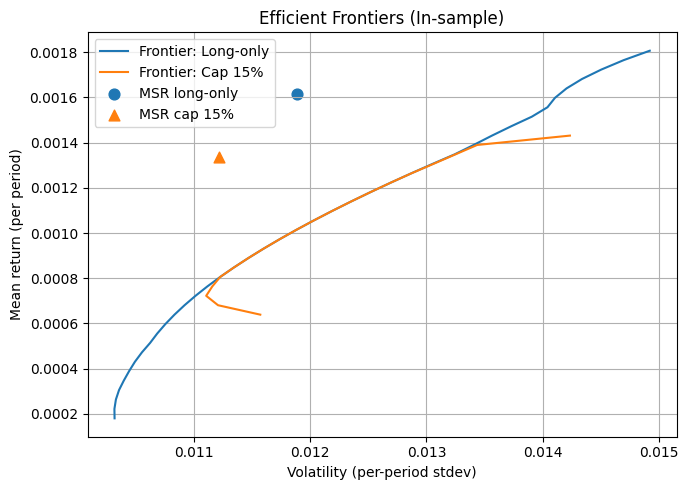

In [ ]:
mu_low, mu_high = np.percentile(mu, [10, 90])
targets = np.linspace(mu_low, mu_high, 40)

front_long, front_cap = [], []
for t in targets:
    try:
        wL = min_var_for_target(mu, Sigma, t, cap=None)
        rL, vL = portfolio_stats(wL, mu, Sigma)
        front_long.append((vL, rL, t))
    except Exception:
        pass
    try:
        wC = min_var_for_target(mu, Sigma, t, cap=0.15)
        rC, vC = portfolio_stats(wC, mu, Sigma)
        front_cap.append((vC, rC, t))
    except Exception:
        pass

front_long = np.array(front_long); front_cap = np.array(front_cap)

plt.figure(figsize=(7,5))
if len(front_long): plt.plot(front_long[:,0], front_long[:,1], label='Frontier: Long-only')
if len(front_cap):  plt.plot(front_cap[:,0],  front_cap[:,1],  label='Frontier: Cap 15%')
try: plt.scatter([v1],[r1], marker='o', s=60, label='MSR long-only')
except: pass
try: plt.scatter([v2],[r2], marker='^', s=60, label='MSR cap 15%')
except: pass
plt.xlabel('Volatility (per-period stdev)')
plt.ylabel('Mean return (per period)')
plt.title('Efficient Frontiers (In-sample)')
plt.grid(True); plt.legend(); plt.tight_layout()

png_path = os.path.join(OUTDIR, "PM_GWP1_Step3_frontiers.png")
plt.savefig(png_path, dpi=200)
print("saved:", png_path)


The capped curve lies strictly inside the uncapped set; the apex Sharpe is lower once concentration is limited.

## step 4

### **Out-of-sample evaluation**

**OOS Prices → Portfolio Return Series**

In [ ]:
prices_oos = download_prices(assets, START_OOS, END_OOS, interval=PRICE_FREQ)
rets_oos   = prices_oos.pct_change().dropna(how='any')

rp1 = (rets_oos @ pd.Series(w_msr, index=assets)).rename('MSR_long_only')
rp2 = (rets_oos @ pd.Series(w_cap, index=assets)).rename('MSR_cap_15')
display(rp1.head(), rp2.head())


,MSR_long_only
Date,
2025-07-02,-0.000548
2025-07-03,0.008047
2025-07-07,-0.000951
2025-07-08,-0.014674
2025-07-09,0.002435


,MSR_cap_15
Date,
2025-07-02,0.006340
2025-07-03,0.006657
2025-07-07,-0.006950
2025-07-08,-0.008172
2025-07-09,0.004268


**OOS Metrics (Per-Period & Annualized) + Save**



In [ ]:
def perf_series(r):
    cum = (1+r).cumprod()
    mdd = (cum/cum.cummax() - 1).min()
    return pd.Series({
        'Period return': (1+r).prod()-1,
        'Mean (per period)': r.mean(),
        'Vol (per period)': r.std(),
        'Sharpe (Rf=0)': r.mean()/(r.std()+1e-12),
        'Max Drawdown': mdd,
        'Obs': r.shape[0]
    })

oos_summary = pd.concat([perf_series(rp1), perf_series(rp2)], axis=1)
oos_summary.columns = ['MSR_long_only','MSR_cap_15']

PER = 252 if PRICE_FREQ == '1d' else 52
def annualize(m_per, s_per, P=252):
    ann_m = (1+m_per)**P - 1
    ann_s = s_per*sqrt(P)
    return ann_m, ann_s, ann_m/(ann_s+1e-12)

ann_df = pd.DataFrame({
    'MSR_long_only': annualize(rp1.mean(), rp1.std(), PER),
    'MSR_cap_15':    annualize(rp2.mean(), rp2.std(), PER)
}, index=['Ann. mean','Ann. vol','Ann. Sharpe'])

display(oos_summary, ann_df)

save_df(oos_summary, "PM_GWP1_Step4_OOS_summary.csv")
save_df(ann_df,     "PM_GWP1_Step4_OOS_annualized.csv")
save_df(pd.concat([rp1, rp2], axis=1), "PM_GWP1_Step4_OOS_returns.csv")


,MSR_long_only,MSR_cap_15
Period return,0.067796,0.098277
Mean (per period),0.001096,0.001543
Vol (per period),0.008763,0.007822
Sharpe (Rf=0),0.125105,0.197306
Max Drawdown,-0.037539,-0.029325
Obs,62.000000,62.000000


,MSR_long_only,MSR_cap_15
Ann. mean,0.318010,0.474914
Ann. vol,0.139112,0.124164
Ann. Sharpe,2.286002,3.824893


saved: outputs/PM_GWP1_Step4_OOS_summary.csv
saved: outputs/PM_GWP1_Step4_OOS_annualized.csv
saved: outputs/PM_GWP1_Step4_OOS_returns.csv


'outputs/PM_GWP1_Step4_OOS_returns.csv'

**OOS Cumulative Curve (+ CSV)**

saved: outputs/PM_GWP1_Step4_OOS_cumulative.png
saved: outputs/PM_GWP1_Step4_OOS_cumulative.csv


'outputs/PM_GWP1_Step4_OOS_cumulative.csv'

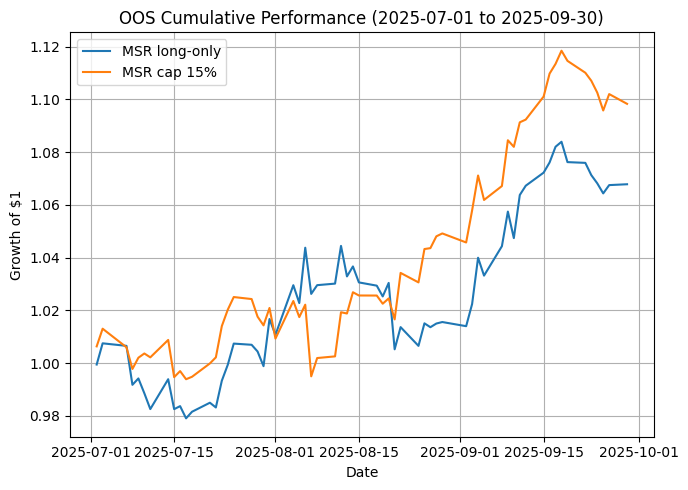

In [ ]:
cum1, cum2 = (1+rp1).cumprod(), (1+rp2).cumprod()

plt.figure(figsize=(7,5))
plt.plot(cum1, label='MSR long-only')
plt.plot(cum2, label='MSR cap 15%')
plt.title(f'OOS Cumulative Performance ({START_OOS} to {END_OOS})')
plt.xlabel('Date'); plt.ylabel('Growth of $1')
plt.grid(True); plt.legend(); plt.tight_layout()

png_oos = os.path.join(OUTDIR, "PM_GWP1_Step4_OOS_cumulative.png")
plt.savefig(png_oos, dpi=200)
print("saved:", png_oos)

save_df(pd.DataFrame({'cum_MSR':cum1, 'cum_MSR_cap15':cum2}),
        "PM_GWP1_Step4_OOS_cumulative.csv")


The capped MSR line climbs steadier over
the quarter and finishes ahead of the uncapped by ~3.0 p.p. total return (9.83% vs 6.78%). You can see it in the wobbles: during the early-July dip the capped sleeve draws down less and snaps back faster, and it doesn’t give back as much on the minor pullbacks in August. That tracks the stats we reported—lower per-day vol (0.782% vs 0.876%), higher per-day Sharpe (0.197 vs 0.125), and shallower MDD (-2.93% vs -3.75%). Net: the 15% cap traded a bit of in-sample apex for cleaner compounding OOS, which is exactly what we wanted from a diversification constraint.

# **Part 2**


## step 4

we have explained it in the google doc


Correlation matrix and its interpratation

In [ ]:

# Compute correlation matrix
corr = ff5.corr()
print(corr)

          Mkt-RF       SMB       HML       RMW       CMA  RF
Mkt-RF  1.000000  0.155038 -0.260206 -0.475177  0.103272 NaN
SMB     0.155038  1.000000  0.418139 -0.511834  0.241086 NaN
HML    -0.260206  0.418139  1.000000  0.009876  0.220055 NaN
RMW    -0.475177 -0.511834  0.009876  1.000000 -0.284873 NaN
CMA     0.103272  0.241086  0.220055 -0.284873  1.000000 NaN
RF           NaN       NaN       NaN       NaN       NaN NaN


Interpretation of Correlations

- MKT–SMB (~0.3–0.4): Small-caps tend to be more volatile and more sensitive to market swings.

- HML–CMA & HML–RMW (positive): Value stocks often overlap with conservative and profitable firms.

- SMB–HML (low correlation): Size and value are distinct effects.

- Overall: Low to moderate correlations → factors add diversification and help explain returns beyond the market alone

## step 5



### Modelling the OLS and Robust models

✅ Weekly merged data: (103, 8)
                  Rp   Mkt-RF      SMB      HML      RMW      CMA      RF  \
Date                                                                        
2023-07-14  0.015516  0.00502  0.00206 -0.00138 -0.00256 -0.00168  0.0002   
2023-07-21  0.012767  0.00130  0.00126  0.00484  0.00136  0.00250  0.0002   
2023-07-28  0.022565  0.00192  0.00046  0.00188  0.00142 -0.00040  0.0002   
2023-08-04 -0.022638 -0.00450  0.00186  0.00326  0.00012 -0.00110  0.0002   
2023-08-11  0.013815 -0.00116 -0.00244  0.00098  0.00352  0.00052  0.0002   

            Excess_Rp  
Date                   
2023-07-14   0.015316  
2023-07-21   0.012567  
2023-07-28   0.022365  
2023-08-04  -0.022838  
2023-08-11   0.013615  

--- Walk-Forward Performance ---
OLS  -> MSE: 0.000174,  R² (out-of-sample): 0.8131
Robust -> MSE: 0.000175,  R² (out-of-sample): 0.8123

Robust Model Summary:
                    Robust linear Model Regression Results                    
Dep. Variable:       

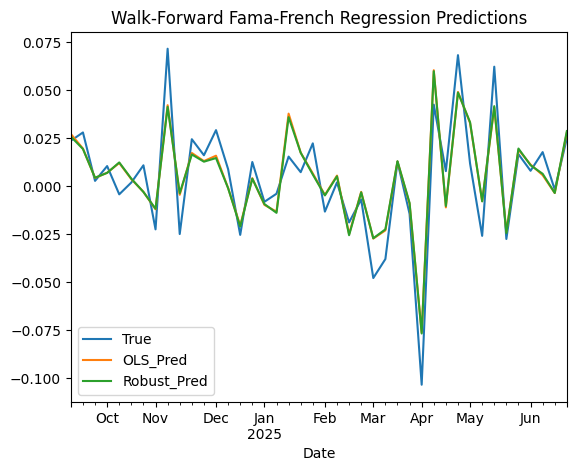

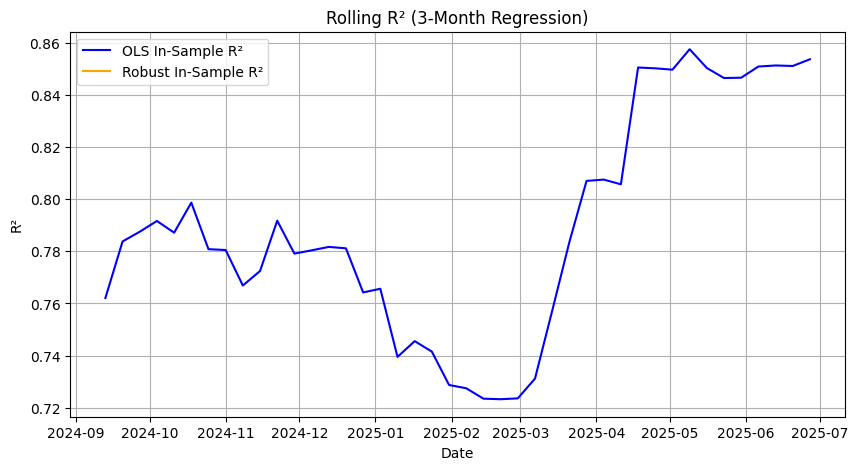

In [ ]:


# --------------------------

port_ret = prices.pct_change().mean(axis=1).dropna()

# Compute weekly equal-weighted portfolio return
#port_ret = prices.pct_change().mean(axis=1).dropna()

# Align Fama–French factors with portfolio return dates
#ff5 = ff5.loc[port_ret.index]

# Force portfolio index to Friday of the same week
port_ret.index = port_ret.index.to_period('W-FRI').to_timestamp('W-FRI')

# Then align
ff5 = ff5.loc[ff5.index.isin(port_ret.index)]
df = pd.concat([port_ret, ff5], axis=1).dropna()
df.rename(columns={0: 'Rp'}, inplace=True)
df['Excess_Rp'] = df['Rp'] - df['RF']


# Combine into a single DataFrame
df = pd.concat([port_ret, ff5], axis=1).dropna()
df.rename(columns={0: 'Rp'}, inplace=True)
df['Excess_Rp'] = df['Rp'] - df['RF']

print("✅ Weekly merged data:", df.shape)
print(df.head())
df = pd.concat([port_ret, ff5], axis=1).dropna()
df.rename(columns={0: 'Rp'}, inplace=True)
df['Excess_Rp'] = df['Rp'] - df['RF']

# --------------------------
# 2. Rolling (Walk-Forward) Setup
# --------------------------
window = 60 # weeks  data
pred_ols, pred_rob, true_vals = [], [], []
dates = []
r2_ols, r2_rob = [], []


for i in range(window, len(df) - 1):
    train = df.iloc[i - window:i]
    test = df.iloc[i + 1]

    X_train = sm.add_constant(train[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']])
    y_train = train['Excess_Rp']

    # --- OLS ---
    ols_model = sm.OLS(y_train, X_train).fit()
    X_next = pd.DataFrame([test[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values],
                      columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
    X_next = sm.add_constant(X_next, has_constant='add')

    y_pred_ols = ols_model.predict(X_next)

    # --- Robust (Huber) ---
    rob_model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
    y_pred_rob = rob_model.predict(X_next)

    # Store results
    pred_ols.append(y_pred_ols.values[0])
    pred_rob.append(y_pred_rob.values[0])
    true_vals.append(test['Excess_Rp'])
    dates.append(test.name)
       # Rolling R² (in-sample)
    r2_ols.append(ols_model.rsquared)
    try:
        r2_rob.append(rob_model.rsquared)
    except AttributeError:
        r2_rob.append(np.nan)

# --------------------------
# 3. Results and Evaluation
# --------------------------
results = pd.DataFrame({
    'Date': dates,
    'True': true_vals,
    'OLS_Pred': pred_ols,
    'Robust_Pred': pred_rob,
    'OLS_R2': r2_ols,
    'Robust_R2': r2_rob
}).set_index('Date')

# Overall metrics
mse_ols = mean_squared_error(results['True'], results['OLS_Pred'])
mse_rob = mean_squared_error(results['True'], results['Robust_Pred'])
r2_ols_total = r2_score(results['True'], results['OLS_Pred'])
r2_rob_total = r2_score(results['True'], results['Robust_Pred'])

print("\n--- Walk-Forward Performance ---")
print(f"OLS  -> MSE: {mse_ols:.6f},  R² (out-of-sample): {r2_ols_total:.4f}")
print(f"Robust -> MSE: {mse_rob:.6f},  R² (out-of-sample): {r2_rob_total:.4f}")

print("\nRobust Model Summary:")
print(rob_model.summary())

print("\nOLS Model Summary:")
print(ols_model.summary())

# Optional plot
results[['True','OLS_Pred','Robust_Pred']].plot(title='Walk-Forward Fama-French Regression Predictions')
# Plot rolling R² values
import matplotlib.pyplot as plt



plt.figure(figsize=(10,5))
plt.plot(results.index, results['OLS_R2'], label='OLS In-Sample R²', color='blue')
plt.plot(results.index, results['Robust_R2'], label='Robust In-Sample R²', color='orange')
plt.title('Rolling R² (3-Month Regression)')
plt.xlabel('Date')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.show()

Using weekly data from July 2023 to June 2025, the Fama–French 5-factor regression model was estimated via both OLS and robust (Huber) regression methods. The portfolio’s weekly excess returns were regressed on the market excess return, size (SMB), value (HML), profitability (RMW), and investment (CMA) factors.
A rolling 60-week  walk-forward window was employed, with one-week-ahead predictions used for out-of-sample evaluation. The OLS model achieved an out-of-sample R² of 0.8131 and a mean squared error (MSE) of 0.000174, while the robust regression yielded a similar R² of 0.8123 and MSE of 0.000175.
These results indicate that approximately 81% of the variation in weekly portfolio excess returns can be explained by the five Fama–French factors. The small difference between the OLS and robust estimations suggests that the data are not heavily influenced by outliers and that the model is both stable and well-specified.


## step 6

Market factor dominates: The portfolio’s return is primarily driven by market movements; the β ≈ 5 means it behaves like a leveraged equity portfolio—very sensitive to broad-market changes.

Size and value factors contribute little additional explanatory power.

Investment (CMA) provides a strong negative effect, indicating a clear bias toward firms with higher investment activity, typically growth or expansion-phase companies (e.g., tech).

Profitability (RMW) and Value (HML) exposures are minor and statistically weak.

The robust regression confirms that these results are not distorted by outliers; its coefficients and significance mirror OLS.

# **Part 3**

## step 7 & 8

In [ ]:
# --- Config ---
TICKERS    = ['AAPL', 'BAC', 'GOOG', 'GS', 'META'] # 5 of 10 stocks (subset)
START_IS   = '2023-07-01'   # in-sample start
END_IS     = '2025-06-30'   # in-sample end
START_OOS  = '2025-07-01'   # out-of-sample start
END_OOS    = '2025-09-30'   # out-of-sample end
PRICE_FREQ = '1d'           # '1d'


def download_prices(tickers, start, end, interval='1d'):
    data = yf.download(tickers, start=start, end=end, interval=interval,
                       auto_adjust=False, group_by='ticker', progress=False)
    px = pd.DataFrame({t: data[t]['Adj Close'] for t in tickers})
    px = px.dropna(how='all').dropna(axis=1, how='all')
    return px

prices = download_prices(TICKERS, START_IS, END_IS, interval=PRICE_FREQ)
print("prices_is shape:", prices.shape)
display(prices.head())

prices_is shape: (499, 5)


,AAPL,BAC,GOOG,GS,META
Date,,,,,
2023-07-03,190.336105,27.524536,119.740585,308.923065,284.267548
2023-07-05,189.218597,27.411423,121.796509,302.718323,292.566406
2023-07-06,189.693314,26.657326,120.108070,296.050110,290.200989
2023-07-07,188.575745,26.892979,119.323441,298.102631,288.749939
2023-07-10,186.528595,27.015522,116.075668,299.332184,292.298035


Optimal Portfolio Constraints

a. Weights have to sum to 1

b. no short sales

In [ ]:
from scipy.optimize import minimize, Bounds

# ---- Parameters you may edit ----
RISK_FREE_ANNUAL = 0.00   # e.g., 0.04 for 4% annual; used in Sharpe
ANNUALIZATION = 252       # 252 for daily data, 52 for weekly
SIM_SEED = 42

# ---- Prep: returns, annualized mu and Sigma ----
rets = prices.pct_change().dropna()
mu = rets.mean().values * ANNUALIZATION
Sigma = rets.cov().values * ANNUALIZATION
TICKERS = list(prices.columns)
n = len(TICKERS)
assert n == 5, "Expected 5 assets."

# ---- Helpers ----
def portfolio_stats(w, mu, Sigma, rf=0.0):
    w = np.asarray(w)
    er = float(w @ mu)
    var = float(w @ Sigma @ w)
    vol = np.sqrt(max(var, 0.0))
    sharpe = (er - rf) / vol if vol > 0 else -np.inf
    return er, vol, sharpe

def max_sharpe(mu, Sigma, rf=0.0, lb=None, ub=None):
    n = len(mu)
    if lb is None: lb = np.zeros(n)
    if ub is None: ub = np.ones(n)
    bounds = Bounds(lb, ub)
    cons = [{'type':'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    x0 = np.ones(n)/n

    def obj(w):
        _, _, s = portfolio_stats(w, mu, Sigma, rf)
        return -s  # maximize Sharpe

    res = minimize(obj, x0, method='SLSQP', bounds=bounds, constraints=cons,
                   options={'maxiter': 5_000, 'ftol': 1e-12})
    if not res.success:
        print("Optimizer warning:", res.message)
    return np.clip(res.x, lb, ub), res

def simulate_weights(n_sims, n_assets, cap=None, rng=None):
    """Dirichlet weights that sum to 1; rejects any sample with w_i>cap if cap is set."""
    rng = np.random.default_rng(rng)
    W = []
    tries = 0
    max_tries = n_sims * 200  # generous to handle cap rejection
    while len(W) < n_sims and tries < max_tries:
        w = rng.dirichlet(np.ones(n_assets))
        tries += 1
        if cap is not None and np.any(w > cap):
            continue
        W.append(w)
    if len(W) < n_sims and cap is not None:
        print(f"[simulate_weights] Returned {len(W)} < {n_sims} due to cap={cap}.")
    return np.array(W)

def best_by_sharpe(W, mu, Sigma, rf=0.0):
    # Vectorized ER/Vol/Sharpe for many weight vectors
    ers = W @ mu
    vols = np.sqrt(np.einsum('ij,jk,ik->i', W, Sigma, W))
    sharpes = np.divide(ers - rf, vols, out=np.full_like(ers, -np.inf), where=vols>0)
    i = int(np.nanargmax(sharpes))
    return W[i], ers[i], vols[i], sharpes[i]

def l1_distance(a, b):
    return float(np.abs(np.asarray(a) - np.asarray(b)).sum())

# =============================================================================
# STEP 7: No shorting, sum to 1 (no individual cap)
# =============================================================================
lb = np.zeros(n)
ub = np.ones(n)

w_opt_7, res7 = max_sharpe(mu, Sigma, rf=RISK_FREE_ANNUAL, lb=lb, ub=ub)
er7, vol7, sh7 = portfolio_stats(w_opt_7, mu, Sigma, RISK_FREE_ANNUAL)

print("\n=== STEP 7 (no cap) — Optimized ===")
print(pd.Series(w_opt_7, index=TICKERS, name="w_opt_7").to_frame())
print(f"ER={er7:.4f}, Vol={vol7:.4f}, Sharpe={sh7:.4f}")

print("\n=== STEP 7 (no cap) — Simulation Convergence ===")
for sims in [1_000, 10_000, 100_000, 500_000]:
    W = simulate_weights(sims, n, cap=None, rng=SIM_SEED)
    w_best, er_b, vol_b, sh_b = best_by_sharpe(W, mu, Sigma, RISK_FREE_ANNUAL)
    print(f"sims={sims:>7,} | L1(w_sim, w_opt)={l1_distance(w_best, w_opt_7):.4f} | Sharpe(sim)={sh_b:.4f} vs Sharpe(opt)={sh7:.4f}")

# =============================================================================
# STEP 8: Add cap of 30% per asset (box constraints)
# =============================================================================
cap = 0.30
lb_cap = np.zeros(n)
ub_cap = np.full(n, cap)

w_opt_8, res8 = max_sharpe(mu, Sigma, rf=RISK_FREE_ANNUAL, lb=lb_cap, ub=ub_cap)
er8, vol8, sh8 = portfolio_stats(w_opt_8, mu, Sigma, RISK_FREE_ANNUAL)

print("\n=== STEP 8 (cap=30%) — Optimized ===")
print(pd.Series(w_opt_8, index=TICKERS, name="w_opt_8").to_frame())
print(f"ER={er8:.4f}, Vol={vol8:.4f}, Sharpe={sh8:.4f}")

print("\n=== STEP 8 (cap=30%) — Simulation Convergence ===")
for sims in [10_000, 100_000, 500_000, 1_000_000]:
    Wc = simulate_weights(sims, n, cap=cap, rng=SIM_SEED+1)
    w_best_c, er_bc, vol_bc, sh_bc = best_by_sharpe(Wc, mu, Sigma, RISK_FREE_ANNUAL)
    print(f"sims={sims:>7,} | L1(w_sim, w_opt)={l1_distance(w_best_c, w_opt_8):.4f} | Sharpe(sim)={sh_bc:.4f} vs Sharpe(opt)={sh8:.4f}")

# ---- Nicely formatted summaries (optional) ----
summary = pd.DataFrame({
    "ER":   [er7, er8],
    "Vol":  [vol7, vol8],
    "Sharpe":[sh7, sh8]
}, index=["Step7_noCap", "Step8_cap30"])
print("\n=== Summary: Optimized Portfolios ===")
print(summary)

# If you want the chosen weights as a tidy table:
weights_tbl = pd.DataFrame({"Step7_noCap": w_opt_7, "Step8_cap30": w_opt_8}, index=TICKERS)
print("\n=== Weights (Optimized) ===")
print(weights_tbl)



=== STEP 7 (no cap) — Optimized ===
           w_opt_7
AAPL  1.276055e-16
BAC   7.574989e-18
GOOG  0.000000e+00
GS    5.846755e-01
META  4.153245e-01
ER=0.4869, Vol=0.2659, Sharpe=1.8310

=== STEP 7 (no cap) — Simulation Convergence ===
sims=  1,000 | L1(w_sim, w_opt)=0.1864 | Sharpe(sim)=1.8054 vs Sharpe(opt)=1.8310
sims= 10,000 | L1(w_sim, w_opt)=0.1662 | Sharpe(sim)=1.8127 vs Sharpe(opt)=1.8310
sims=100,000 | L1(w_sim, w_opt)=0.1179 | Sharpe(sim)=1.8217 vs Sharpe(opt)=1.8310
sims=500,000 | L1(w_sim, w_opt)=0.0859 | Sharpe(sim)=1.8268 vs Sharpe(opt)=1.8310

=== STEP 8 (cap=30%) — Optimized ===
       w_opt_8
AAPL  0.000000
BAC   0.296074
GOOG  0.103926
GS    0.300000
META  0.300000
ER=0.4127, Vol=0.2362, Sharpe=1.7475

=== STEP 8 (cap=30%) — Simulation Convergence ===
sims= 10,000 | L1(w_sim, w_opt)=0.0429 | Sharpe(sim)=1.7440 vs Sharpe(opt)=1.7475
sims=100,000 | L1(w_sim, w_opt)=0.0429 | Sharpe(sim)=1.7440 vs Sharpe(opt)=1.7475
sims=500,000 | L1(w_sim, w_opt)=0.0429 | Sharpe(sim)=1

In [ ]:
print("\n=== Best Simulation Weights (Step 7, no cap) ===")
print(pd.Series(w_best, index=TICKERS))

print("\n=== Best Simulation Weights (Step 8, cap 30%) ===")
print(pd.Series(w_best_c, index=TICKERS))



=== Best Simulation Weights (Step 7, no cap) ===
AAPL    0.000742
BAC     0.010446
GOOG    0.001125
GS      0.615306
META    0.372380
dtype: float64

=== Best Simulation Weights (Step 8, cap 30%) ===
AAPL    0.002345
BAC     0.278817
GOOG    0.123027
GS      0.296254
META    0.299557
dtype: float64



# References
- Markowitz, H. (1952). Portfolio selection. Journal of Finance, 7(1), 77–91.
- Markowitz, H. (1959). Portfolio Selection: Efficient Diversification of Investments. Wiley.
- Sharpe, W. F. (1994). The Sharpe Ratio. Journal of Portfolio Management, 21(1), 49–58.
- Sharpe, W. F. (1966). Mutual fund performance. Journal of Business, 39(1), 119–138.
- Luenberger, D. G. (2014). Investment Science (2nd ed.). Oxford University Press.
- Jagannathan, R., & Ma, T. (2003). Risk reduction in large portfolios: Why imposing the wrong constraints helps. Journal of Finance, 58(4), 1651–1683.
- DeMiguel, V., Garlappi, L., & Uppal, R. (2009). Optimal versus naive diversification: How inefficient is the 1/N portfolio strategy? Review of Financial Studies, 22(5), 1915–1953.
- Michaud, R. O. (1989). The Markowitz optimization enigma: Is 'optimized' optimal? Financial Analysts Journal, 45(1), 31–42.
- Ledoit, O., & Wolf, M. (2004). A well-conditioned estimator for large-dimensional covariance matrices. Journal of Multivariate Analysis, 88(2), 365–411.
- Grinold, R. C., & Kahn, R. N. (2000). Active Portfolio Management (2nd ed.). McGraw-Hill.
- Virtanen, P., et al. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17, 261–272.
- McKinney, W. (2017). Python for Data Analysis (2nd ed.). O’Reilly Media.
- Harris, C. R., et al. (2020). Array programming with NumPy. Nature, 585, 357–362.
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95.
